# XD SEGMENT GENERATOR

This notebook takes a list of traffic signal coordinates and joins it to the INRIX XD segments

Download the latest map release from: https://map-data-downloader.inrix.com/

Currently using map release 21.2

## Before proceeding, archive the old geojson file and the daily_download_segments.txt file so they can be compared when done. 

### Don't forget to update map release number in the INXRIX_XD_Downloader

In [2]:
import pandas as pd
#import pyodbc
import geopandas as gpd
from shapely.geometry import Point, Polygon
#import xlrd
import matplotlib.pyplot as plt
#import rtree
import numpy as np

# Import XD Segments and Signal Coordinates

In [15]:
#Import the Oregon map
path_gjs = '//scdata2/signalshar/Data_Analysis/INRIX_API/USA_Oregon.geojson'
xd_seg = gpd.read_file(path_gjs)
#xd_seg.plot(figsize=(15,15))
xd_seg = xd_seg.drop(['OID', 'FRC', 'ToExport', 'Lanes', 'RoadNumber', 'PrimaryTmc', 'RoadList', 'XDGroup', 'ShapeSRID','Country', 'State', 'PostalCode','SlipRoad', 'SpecialRoa', 'IsConnecto', 'AllTmcList'], axis=1)
#xd_seg = xd_seg.astype({'XDSegID': int, 'PreviousXD' : int, 'NextXDSegI' : int}) contains nan so can't int
print(xd_seg.dtypes)
xd_seg.head(2)

XDSegID          int64
PreviousXD     float64
NextXDSegI     float64
Miles          float64
RoadName        object
County          object
StartLat       float64
StartLong      float64
EndLat         float64
EndLong        float64
Bearing         object
geometry      geometry
dtype: object


,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,Bearing,geometry
0,116331545,NaN,NaN,0.061197,SE 1ST AVE,MALHEUR,44.02524,-116.9602,44.02504,-116.9590,E,"LINESTRING (-116.96020 44.02525, -116.96004 44..."
1,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,S,"LINESTRING (-116.94350 44.02635, -116.94351 44..."


In [4]:
# Import signal coordinates from Signals Assets spreadsheet. Eventually add signals from other agencies too.
path = "//Scdata/Traffic Signals/Final Cabinet Prints/ODOT_Signals_Assets.xlsm"
df = pd.read_excel(path, engine='openpyxl', sheet_name='SIGNALS', header=2, usecols = "A:B, E:F")
df['Longitude'] = df['Longitude'].astype(float)
df.rename(columns={'TSSU ID':'TSSU'}, inplace = True)

#define a function to add leading 0 to TSSU
def zero(x):
    return str(0) + str(x) if len(str(x)) == 4 else str(x)
df['TSSU'] = df['TSSU'].apply(lambda x : zero(x))
df.head(2)

,TSSU,District,Latitude,Longitude
0,01001,1,46.024203,-123.911675
1,01005,1,45.979187,-123.926714


#### Some signal coordinates are off. 
Highway mileposts end before signal and/or disputes over ownership, so correcting those here.

In [5]:
#UPDATE COORDINATES FOR SPECIFIC SIGNALS
df.loc[df.TSSU == '2B502', 'Latitude'] = 45.340399
df.loc[df.TSSU == '2B502', 'Longitude'] = -122.773652
df.loc[df.TSSU == '04130', 'Latitude'] = 44.555328
df.loc[df.TSSU == '04130', 'Longitude'] = -123.279258
df.loc[df.TSSU == '04002', 'Latitude'] = 44.889723
df.loc[df.TSSU == '04002', 'Longitude'] = -124.024290
df.loc[df.TSSU == '06025', 'Latitude'] = 43.212781
df.loc[df.TSSU == '06025', 'Longitude'] = -123.351629

In [6]:
#Convert signals to a georeferenced geodataframe
crs = {'init' : 'epsg:4326'} #coordinate reference system
points = df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
signals = gpd.GeoDataFrame(df, crs=crs, geometry=points)
# signals.to_crs(xd_seg.crs, inplace=True) #what does this do?
#signals

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:title={'center':'XD Segments with Traffic Signals'}>

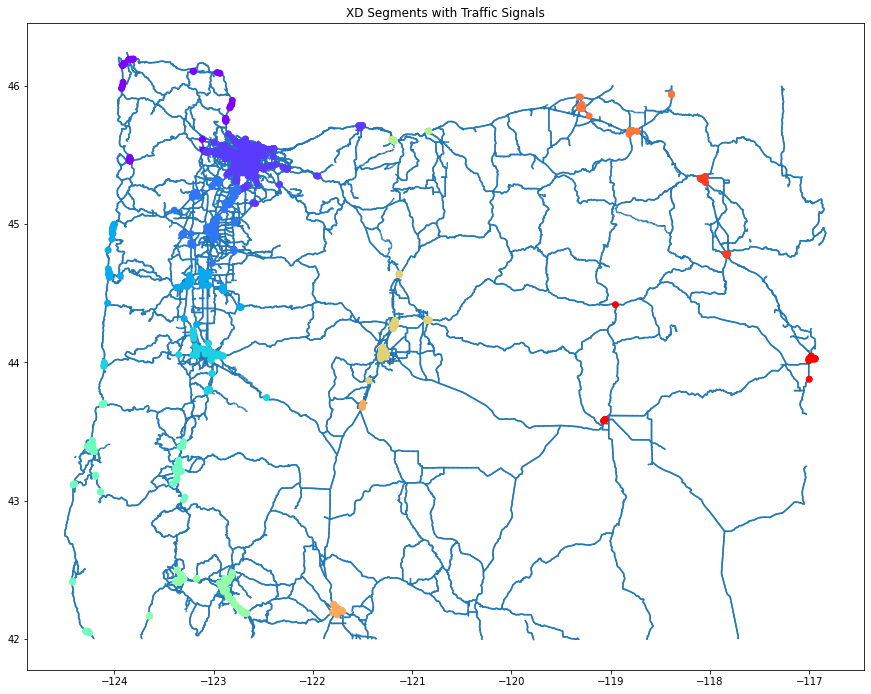

In [6]:
# Plot XD Segments and Signals together to see that it's working
fix, ax = plt.subplots(1, figsize=(15,15))
plt.title('XD Segments with Traffic Signals')
xd_seg.plot(ax=ax, zorder=0)
signals.plot(ax=ax, cmap='rainbow', column='District', zorder=10)

# Spatial Join Signals and XD Segments

Create buffer arround signal points and join them with intersections of XD segments

Then remove TSSU-XD pairs where the XD segment starts near the signal (is moving away)

In [7]:
#create buffer around each signal point
signals['geometry'] = signals['geometry'].buffer(0.0002060) #75ft, One degree of latitude equals approximately 364,000 feet (69 miles)
#join signal buffers to XD segments
join = gpd.sjoin(xd_seg, signals, how='inner', op='intersects')
#create uniqe identifier key for TSSU-XD pairs
join['key'] = join[['TSSU', 'XDSegID']].astype(str).agg('-'.join, axis=1)
print(join.columns.tolist())
print(len(join.index))

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  after removing the cwd from sys.path.


['XDSegID', 'PreviousXD', 'NextXDSegI', 'Miles', 'RoadName', 'County', 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'Bearing', 'geometry', 'index_right', 'TSSU', 'District', 'Latitude', 'Longitude', 'key']
7883


In [8]:
#create a copy of join to apply a negative join to remove segments where the startpoint is at the signal
#we want to see segments going towards the signal, not away from it

join_point = join[['key', 'StartLong', 'StartLat', 'TSSU']].copy()
#join_point = join_point[join_point.TSSU.isin(['03008'])] #testing by filter to mission at airport

join_point['XD_start_point'] = join_point.apply(lambda row: Point(row.StartLong, row.StartLat), axis=1) #convert XD start coords to points
join_point = join_point.set_geometry('XD_start_point')

negative = gpd.sjoin(signals, join_point, op='contains')
#This join results in adjacent signals joining to points that should be removed for them, but not their neighbors
#Thus, filter down to only where TSSU from the signal matches the XD
negative = negative[negative.TSSU_left == negative.TSSU_right]
negative


C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  # Remove the CWD from sys.path while we load stuff.


,TSSU_left,District,Latitude,Longitude,geometry,index_right,key,StartLong,StartLat,TSSU_right
0,01001,1,46.024203,-123.911675,"POLYGON ((-123.91147 46.02420, -123.91147 46.0...",80713,01001-1237049569,-123.91164,46.02418,01001
0,01001,1,46.024203,-123.911675,"POLYGON ((-123.91147 46.02420, -123.91147 46.0...",9937,01001-124978435,-123.91164,46.02418,01001
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92041 45.99309, -123.92041 45.9...",18742,01006-385689177,-123.92058,45.99310,01006
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92041 45.99309, -123.92041 45.9...",50541,01006-1236855939,-123.92058,45.99310,01006
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92041 45.99309, -123.92041 45.9...",51935,01006-1236865950,-123.92058,45.99310,01006
...,...,...,...,...,...,...,...,...,...,...
1474,14075,14,44.024821,-117.005110,"POLYGON ((-117.00490 44.02482, -117.00491 44.0...",95,14075-120338393,-117.00513,44.02484,14075
1475,14076,14,44.039957,-116.985778,"POLYGON ((-116.98557 44.03996, -116.98557 44.0...",118,14076-120528091,-116.98576,44.03996,14076
1475,14076,14,44.039957,-116.985778,"POLYGON ((-116.98557 44.03996, -116.98557 44.0...",85,14076-116926056,-116.98576,44.03996,14076
1476,14077,14,44.044171,-116.979363,"POLYGON ((-116.97916 44.04417, -116.97916 44.0...",15,14077-116358624,-116.97933,44.04417,14077


In [11]:
#Now do a left outer join excluding the intersection (negative join)

#two step solution, but found a one line solution below
#dim_signals_XD = pd.merge(join, negative[['key']], on=['key'], how='outer', indicator=True)
#dim_signals_XD = dim_signals_XD[dim_signals_XD['_merge']=='left_only']

dim_signals_XD=pd.merge(join,negative[['key']],on=['key'],how="outer",indicator=True).query('_merge=="left_only"').drop(['_merge', 'index_right'], axis=1)
#dim_signals_XD.drop(['OID', 'FRC', 'To'])
print(len(dim_signals_XD.index))
print(dim_signals_XD.dtypes)
dim_signals_XD.head(2)

4222
XDSegID          int64
PreviousXD     float64
NextXDSegI     float64
Miles          float64
RoadName        object
County          object
StartLat       float64
StartLong      float64
EndLat         float64
EndLong        float64
Bearing         object
geometry      geometry
TSSU            object
District         int64
Latitude       float64
Longitude      float64
key             object
dtype: object


,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,Bearing,geometry,TSSU,District,Latitude,Longitude,key
0,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,S,"LINESTRING (-116.94350 44.02635, -116.94351 44...",14037,14,44.02475,-116.943451,14037-116337789
3,120916743,NaN,NaN,0.080331,SE GOODFELLOW ST,MALHEUR,44.02363,-116.9431,44.02473,-116.9435,N,"LINESTRING (-116.94314 44.02359, -116.94318 44...",14037,14,44.02475,-116.943451,14037-120916743


# Short Segments
Sometimes there are slip lanes that cause XD segments to be broken up really small.

That can leave a coridor disjointed. 

To overcome this, if a segment is less than 300 ft then also add the previous segment

In [30]:
ft = 300 #minimum length of segment in feet
short = dim_signals_XD[dim_signals_XD.Miles < ft/5280]
short = short[['PreviousXD', 'TSSU', 'District', 'Latitude', 'Longitude']].copy().dropna()
short = short.rename(columns={'PreviousXD' : 'XDSegID'})
short.XDSegID = short.XDSegID.astype('int64')
print(len(short.index))
#print(short.dtypes)
short.info()

435
<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 125 to 7676
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   XDSegID    435 non-null    int64  
 1   TSSU       435 non-null    object 
 2   District   435 non-null    int64  
 3   Latitude   435 non-null    float64
 4   Longitude  435 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 20.4+ KB


In [31]:
# Join the list of short segments back to the list of all segments to get rest of columns
short = short.merge(xd_seg, on='XDSegID', how='inner')
short['key'] = short[['TSSU', 'XDSegID']].astype(str).agg('-'.join, axis=1)
print(len(short.index))
# Concat the list of short segments to rest of segments
# ALL COLUMNS MUST MATCH!
dim_signals_XD = pd.concat([dim_signals_XD, short])
print(len(dim_signals_XD))
dim_signals_XD.head(2)

433
4655


,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,Bearing,geometry,TSSU,District,Latitude,Longitude,key
0,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,S,"LINESTRING (-116.94350 44.02635, -116.94351 44...",14037,14,44.02475,-116.943451,14037-116337789
3,120916743,NaN,NaN,0.080331,SE GOODFELLOW ST,MALHEUR,44.02363,-116.9431,44.02473,-116.9435,N,"LINESTRING (-116.94314 44.02359, -116.94318 44...",14037,14,44.02475,-116.943451,14037-120916743


# CALCULATING BASE TRAVEL TIMES
Import speed limits from TPAU. This will be used instead of "free flow speed"

There are multiple copies of XD segments, I think when there is a speed limit or AADT change within a segment. 

For now just average the speed/AADT?

In [32]:
speed_limits = pd.read_csv('//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/speed_limits.csv', index_col='XDSegID')
speed_limits = speed_limits.groupby('XDSegID').mean() 
#Check that all the XD ID's are unique
print(len(speed_limits.index))
print(speed_limits.index.nunique())
speed_limits.head(2)


21912
21912


,AADT,SPEED
XDSegID,,
120553168,11900.0,70.0
120615562,1400.0,65.0


In [33]:
#Join speed limits and AADT
dim_signals_XD = dim_signals_XD.merge(speed_limits, on='XDSegID', how='left')
dim_signals_XD.head(2)

,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,Bearing,geometry,TSSU,District,Latitude,Longitude,key,AADT,SPEED
0,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,S,"LINESTRING (-116.94350 44.02635, -116.94351 44...",14037,14,44.02475,-116.943451,14037-116337789,NaN,NaN
1,120916743,NaN,NaN,0.080331,SE GOODFELLOW ST,MALHEUR,44.02363,-116.9431,44.02473,-116.9435,N,"LINESTRING (-116.94314 44.02359, -116.94318 44...",14037,14,44.02475,-116.943451,14037-120916743,NaN,NaN


In [34]:
# Calculate travel time
dim_signals_XD['travel_time_minutes'] = dim_signals_XD.Miles.div(dim_signals_XD.SPEED).mul(60)
dim_signals_XD.tail(2)

,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,Bearing,geometry,TSSU,District,Latitude,Longitude,key,AADT,SPEED,travel_time_minutes
4653,1236989872,440966930.0,1.237059e+09,0.775975,HIGHBANKS RD,LANE,44.05561,-122.92634,44.05621,-122.94030,W,"LINESTRING (-122.92635 44.05560, -122.92639 44...",5CS199,5,44.055989,-122.940265,5CS199-1236989872,NaN,NaN,NaN
4654,1236889793,385870329.0,1.236991e+09,0.082998,STATE ST,MARION,44.94040,-123.04049,44.94080,-123.04209,W,"LINESTRING (-123.04050 44.94037, -123.04065 44...",3CS316,3,44.940859,-123.042294,3CS316-1236889793,NaN,NaN,NaN


# Group XD Segments

Add a group id to each segment, using the previous/next ID columns

In [35]:
#join[['key', 'StartLong', 'StartLat']].copy()
g = dim_signals_XD[['XDSegID', 'PreviousXD', 'NextXDSegI']].copy().drop_duplicates(subset=['XDSegID', 'PreviousXD', 'NextXDSegI']).set_index('XDSegID')
g

,PreviousXD,NextXDSegI
XDSegID,,
116337789,NaN,NaN
120916743,NaN,NaN
383985787,1.187523e+09,4.289573e+08
1187436457,4.289573e+08,1.187436e+09
116342301,NaN,NaN
...,...,...
385983378,1.236864e+09,1.236972e+09
448838542,4.488385e+08,1.236917e+09
440939738,4.489045e+08,1.237047e+09


In [36]:
g['group'] = ""
group = 0
l = []

for i in range(len(g)):
    x = g.index[i]
    if x not in l:
        group += 1
        p = g.PreviousXD.loc[x]
        n = g.NextXDSegI.loc[x]
        g.group.loc[x] = group
        while not pd.isnull(p):
            try:
                g.group.loc[int(p)] = group
                l.append(int(p))
                p = g.PreviousXD.loc[p]
            except: 
                break
        while not pd.isnull(n):
            try:
                g.group.loc[int(n)] = group
                l.append(int(n))
                n = g.PreviousXD.loc[n]
            except:
                break
        l.append(x)
g=g[['group']].copy()
g

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,group
XDSegID,
116337789,1
120916743,2
383985787,3
1187436457,4
116342301,5
...,...
385983378,179
448838542,2503
440939738,1347


In [37]:
#Join the group # to the dim table
dim_signals_XD = dim_signals_XD.merge(g, on='XDSegID', how='left')
dim_signals_XD.head(2)

,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,...,geometry,TSSU,District,Latitude,Longitude,key,AADT,SPEED,travel_time_minutes,group
0,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,...,"LINESTRING (-116.94350 44.02635, -116.94351 44...",14037,14,44.02475,-116.943451,14037-116337789,NaN,NaN,NaN,1
1,120916743,NaN,NaN,0.080331,SE GOODFELLOW ST,MALHEUR,44.02363,-116.9431,44.02473,-116.9435,...,"LINESTRING (-116.94314 44.02359, -116.94318 44...",14037,14,44.02475,-116.943451,14037-120916743,NaN,NaN,NaN,2


# Calculate distance from signal to segment end point
This is to check for signal coordinates being off

In [38]:
#use law of haversines to calculate distance between two points
dim_signals_XD['distance'] = \
    2 * 3959 * 5280 \
        * np.arcsin( \
            np.sqrt( \
                np.sin( ( dim_signals_XD.Latitude - dim_signals_XD.EndLat ) * np.pi / 360 ) ** 2 \
                    + np.cos( dim_signals_XD.EndLat * np.pi / 180 ) \
                        * np.cos( dim_signals_XD.Latitude * np.pi / 180 )
                        * np.sin( (dim_signals_XD.Longitude - dim_signals_XD.EndLong ) * np.pi / 360 ) ** 2
    ))

dim_signals_XD.head(2)

,XDSegID,PreviousXD,NextXDSegI,Miles,RoadName,County,StartLat,StartLong,EndLat,EndLong,...,TSSU,District,Latitude,Longitude,key,AADT,SPEED,travel_time_minutes,group,distance
0,116337789,NaN,NaN,0.111931,NE GOODFELLOW ST,MALHEUR,44.02635,-116.9435,44.02473,-116.9435,...,14037,14,44.02475,-116.943451,14037-116337789,NaN,NaN,NaN,1,14.884496
1,120916743,NaN,NaN,0.080331,SE GOODFELLOW ST,MALHEUR,44.02363,-116.9431,44.02473,-116.9435,...,14037,14,44.02475,-116.943451,14037-120916743,NaN,NaN,NaN,2,14.884496


In [39]:
test = dim_signals_XD.groupby('TSSU').min()
test = test[['distance']].copy()
test[test.distance.between(70, 150)]

,distance
TSSU,
04081,117.283958
05099,122.152942
08019,130.959612
08151,105.042720
13008,73.235638
2B078,75.826202
2B081,80.736669
2B355,72.686834
2BCP817,83.340682


# Save Results to Files on signalshar

In [40]:
#create unique set of XD Segment IDs for use in calling data from the API
path = '//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/daily_download_segments.txt'
segments = set(dim_signals_XD['XDSegID'])
with open(path, 'w') as f:
    f.write(repr(segments)[1:-1])

In [41]:
#save the signals_xd dimension file
dim_signals_XD.to_csv('//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/dim_signals_XD.csv', index=False)
#dim_signals_XD.to_csv('//scdata2/signalshar/Data_Analysis/Data/Performance/dim_signals_XD.csv', index=False)

In [42]:
dim_signals_XD.dtypes


XDSegID                   int64
PreviousXD              float64
NextXDSegI              float64
Miles                   float64
RoadName                 object
County                   object
StartLat                float64
StartLong               float64
EndLat                  float64
EndLong                 float64
Bearing                  object
geometry               geometry
TSSU                     object
District                  int64
Latitude                float64
Longitude               float64
key                      object
AADT                    float64
SPEED                   float64
travel_time_minutes     float64
group                    object
distance                float64
dtype: object